# Steering Angle Prediction - CNN

**Abedin Sherifi**

In this project, techniques in DL supervised learning have been applied to predict the vector of
steering angles required to navigate a car through some specified trajectory. The dataset is based from Udacity (https://github.com/udacity/self-driving-car/tree/master/datasets).

Each file in the dataset describes a trajectory (roughly a 15 to 45 minute drive), over the duration
of which attributes are collected. For each point along the trajectory, the steering angle at that
point is recorded along with the GPS coordinates of the car, the instantaneous speed at which the car is traveling, and a set of 3 images {left, center, right} captured by onboard forward facing cameras in the vehicle.

## Helpful Functions and Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import scipy
from scipy import ndimage
import imageio
import os
import glob
import h5py
import skimage
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
#from scipy.misc import imread, imsave, imresize
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Convolution2D,MaxPooling2D
from keras import backend as K
K.set_image_data_format('channels_first')
from PIL import Image
import pandas as pd
import cv2
from keras import layers
from keras.callbacks import EarlyStopping
from keras import models
from keras.layers import (Input, Dense, Activation, ZeroPadding2D,
BatchNormalization, Flatten, Conv2D, concatenate, Lambda)
from keras.layers import (AveragePooling2D, MaxPooling2D, Dropout,
GlobalMaxPooling2D, GlobalAveragePooling2D)
from keras.models import Model, load_model
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
#%matplotlib inline
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

Using TensorFlow backend.
/home/dino/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dino/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dino/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dino/anaconda3/lib/python3.7/site-packages/tensorflow/py

## Image pre-processing

The code below will read in images and normalize them. Then it will perform central cropping and rescaling to 48 x 64.

In [4]:
def preprocess_img(img, name):
    sobel_dir = 'right/'
    im = img.astype('int32')
    dx = ndimage.sobel(im, 1)
    dy = ndimage.sobel(im, 0)
    mag = np.hypot(dx, dy)
    mag *= 255.0 / np.max(mag)
    
    #central scrop
    min_side = min(mag.shape[:-1])
    centre = mag.shape[0]//2, mag.shape[1]//2
    mag = mag[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
    
    #rescale to standard size
    mag = imresize(mag, (48, 64))

    print(os.path.join(sobel_dir,name))
    imageio.imsave(os.path.join(sobel_dir,name), mag)
    
    return img


root_dir = 'right_original/'

for f in os.listdir(root_dir):
    im = imageio.imread(os.path.join(root_dir,f), format='jpeg')
    img = preprocess_img(im, f)

/home/dino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


right/1479426035210649355.jpg
right/1479424394862109784.jpg
right/1479426510843159497.jpg
right/1479424504876349807.jpg
right/1479424728165807597.jpg
right/1479426347664395189.jpg
right/1479424847786871399.jpg
right/1479424934752211212.jpg
right/1479426415226298026.jpg
right/1479424997563277562.jpg
right/1479424222778419187.jpg
right/1479425861580223573.jpg
right/1479426268050403878.jpg
right/1479425166693071065.jpg
right/1479426403174113428.jpg
right/1479424271386974314.jpg
right/1479424667905121051.jpg
right/1479425022617632190.jpg
right/1479425937993561606.jpg
right/1479426491089727181.jpg
right/1479424797327915987.jpg
right/1479425896386923917.jpg
right/1479424659903701883.jpg
right/1479426305056932418.jpg
right/1479425898286618993.jpg
right/1479426357766223483.jpg
right/1479425816624638951.jpg
right/1479424360802937643.jpg
right/1479426359716606374.jpg
right/1479424373404970917.jpg
right/1479424320045548808.jpg
right/1479425941294089081.jpg
right/1479424372654857759.jpg
right/1479

KeyboardInterrupt: 

## Pre-processing of csv file

The code below reads in the csv file. Looks for the filename column and finds out all the rows containing center or left or right. Then it finds the angle column and concatenates the angle column with the particular camera pictures from the filename. The code also drops any NAs in any of the rows. 

In [2]:
df = pd.read_csv('interpolated.csv')

center_pre = df['filename'].str.contains('center')
left_pre = df['filename'].str.contains('left')
right_pre = df['filename'].str.contains('right')

center_df = df['filename'].loc[center_pre]
left_df = df['filename'].loc[left_pre]
right_df = df['filename'].loc[right_pre]

center_df = pd.DataFrame(center_df, columns=['filename'])
left_df = pd.DataFrame(left_df, columns=['filename'])
right_df = pd.DataFrame(right_df, columns=['filename'])

col_angle = df['angle']
col_file_center = center_df['filename']
col_file_left = left_df['filename']
col_file_right = right_df['filename']

#angle columns for center/left/right images
angle_center = pd.concat([col_angle,col_file_center], axis=1)
angle_center = angle_center.dropna(axis=0, how='any')

angle_left = pd.concat([col_angle,col_file_left], axis=1)
angle_left = angle_left.dropna(axis=0, how='any')

angle_right = pd.concat([col_angle,col_file_right], axis=1)
angle_right = angle_right.dropna(axis=0, how='any')

r = angle_right['angle'].astype(float)
print(angle_center)
print(angle_left)
print(angle_right)
print(r)

no_of_examples = len(r)
print(no_of_examples)

           angle                        filename
2       0.001039  center/1479424215880976321.jpg
5       0.003491  center/1479424215930775951.jpg
8       0.003491  center/1479424215980916687.jpg
11      0.005236  center/1479424216030737492.jpg
14      0.006234  center/1479424216080827865.jpg
...          ...                             ...
101382  0.000000  center/1479426572143513175.jpg
101385  0.000000  center/1479426572193253275.jpg
101388  0.000000  center/1479426572243347757.jpg
101391  0.000000  center/1479426572293518518.jpg
101394  0.000000  center/1479426572343447996.jpg

[33808 rows x 2 columns]
           angle                      filename
0       0.000360  left/1479424215873184606.jpg
3       0.003491  left/1479424215922817911.jpg
6       0.003491  left/1479424215972815517.jpg
9       0.004670  left/1479424216022820692.jpg
12      0.005554  left/1479424216073039735.jpg
...          ...                           ...
101381  0.000000  left/1479426572117617210.jpg
101384  0.

## Generating training and testing sets

The code below will append all the images from a directory to train_x which is then converted to an array. The code will also convert r from the cells above to an array and assigned to train_y which then gets reshaped. 

In [3]:
train_x = []
root_dir = 'right_sobel/'

for f in os.listdir(root_dir):
    img = imageio.imread(os.path.join(root_dir,f), format='jpeg')
    train_x.append(img)

train_x = np.array(train_x)
print(train_x.shape)

(33783, 48, 64, 3)


In [4]:
train_y = np.array(r)
train_y = np.reshape(train_y,[train_y.shape[0],1])

print(train_y.shape)

(33783, 1)


## Train Test Split

The code below will split the input data x and y to x train/test and y train/test.

In [5]:
x_train,x_test,y_train,y_test = train_test_split(train_x,train_y,random_state=42,test_size=.20)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(27026, 48, 64, 3)
(27026, 1)
(6757, 48, 64, 3)
(6757, 1)


## Model Definition

The code below defines the model. Convolution2D layers are used for the input of an image in 3D (height, width, channels).

At the core of the model below we have the **dense** layers. It is a widely used layer for creating a deeply connected layer in the neural network where each of the neurons of the dense layers receives input from all neurons of the previous layer.

Another used layer is the **flatten** layer which as its name suggests, it is used for flattening of the input.

The **Convolution2D** layer is the convolutional layer that performs an operation called a “convolution“.

Convolution is a linear operation that involves the multiplication of a set of weights with the input. This multiplication is performed between an array of input data and a two-dimensional array of weights, called a filter or a kernel.

In this particular model, the first number which is 12 implies the number of filters to be used for convolution operations. The (3,3) input is the kernel size which dictates the length of the convolution window.

In [20]:
IMAGE_HEIGHT = 48 
IMAGE_WIDTH = 64

model = Sequential()
model.add(Convolution2D(12, (3,3), activation='relu', padding='same',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), data_format='channels_first'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
global model_run
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=4, verbose=1, mode='auto')
model_run = model.fit(x_train, y_train, validation_data=(x_test,y_test),callbacks=[monitor, ModelCheckpoint('model_final_exam.h5', save_best_only=True)], nb_epoch=20, batch_size=1024)

/home/dino/anaconda3/lib/python3.7/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 27026 samples, validate on 6757 samples
Epoch 1/20
27026/27026 [==============================] - 4s 147us/step - loss: 109.2352 - val_loss: 6.1829
Epoch 2/20
27026/27026 [==============================] - 4s 147us/step - loss: 3.1788 - val_loss: 1.8403
Epoch 3/20
27026/27026 [==============================] - 4s 142us/step - loss: 1.5676 - val_loss: 1.2338
Epoch 4/20
27026/27026 [==============================] - 4s 143us/step - loss: 1.1121 - val_loss: 0.9368
Epoch 5/20
27026/27026 [==============================] - 4s 142us/step - loss: 0.8505 - val_loss: 0.7374
Epoch 6/20
27026/27026 [==============================] - 4s 142us/step - loss: 0.6737 - val_loss: 0.6004
Epoch 7/20
27026/27026 [==============================] - 4s 142us/step - loss: 0.5485 - val_loss: 0.5015
Epoch 8/20
27026/27026 [==============================] - 4s 143us/step - loss: 0.4574 - val_loss: 0.4278
Epoch 9/20
27026/27026 [==============================] - 4s 149us/step - loss: 0.3888 - val_loss: 0.

## Plot of loss and val_loss from fitting the model in the steps above

In [22]:
def plot_loss_val_loss(model_run,title='Loss and Val_Loss'):
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(model_run.history['loss'])
    plt.plot(model_run.history['val_loss'])
    plt.legend(['Training', 'Testing'])

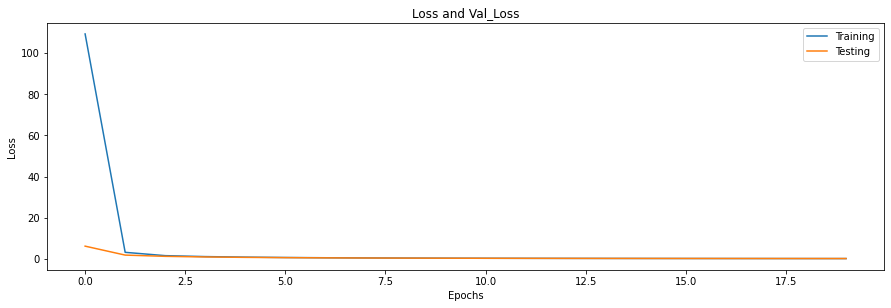

In [23]:
plot_loss_val_loss(model_run)

## Prediction and plot of y_test and prediction for comparison purposes

In [24]:
preds = model.predict(x_test)

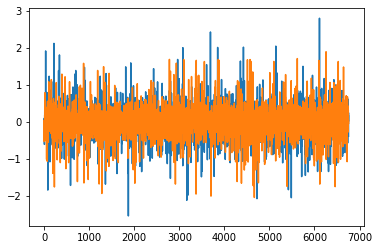

In [25]:
plt.plot(preds)
plt.plot(y_test);

Score (RMSE): 0.4037827529707427


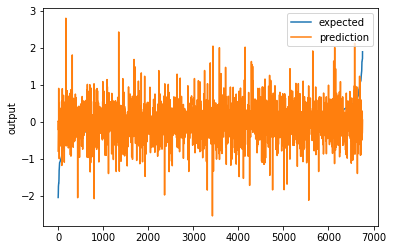

In [26]:
from sklearn import metrics

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

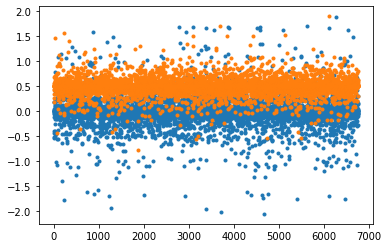

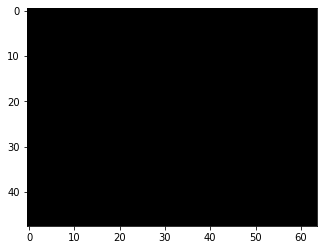

In [29]:
preds = model.predict(x_test)
steer_preds = (preds.reshape([-1])+1)/2.
plt.plot(np.array([y_test[:,0],steer_preds.reshape(len(steer_preds))]).T,'.')



# Animation!
def get_point(s,start=0,end=128,height= 16):
    X = int(s*(end-start))
    if X < start:
        X = start
    if X > end:
        X = end
    return (X,height)

val_idx = 0
figure = plt.figure()
imageplot = plt.imshow(np.zeros((48, 64, 3), dtype=np.uint8))

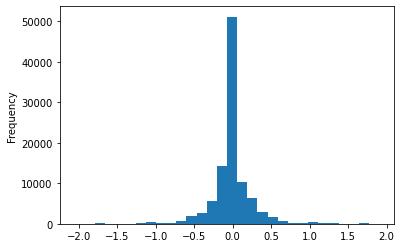

In [30]:
df['angle'].plot.hist(bins=30)
plt.show()

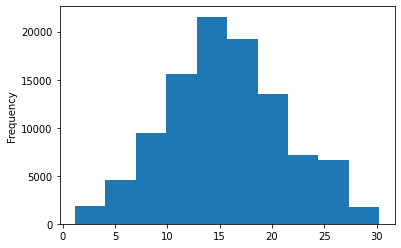

In [31]:
df['speed'].plot.hist()
plt.show()

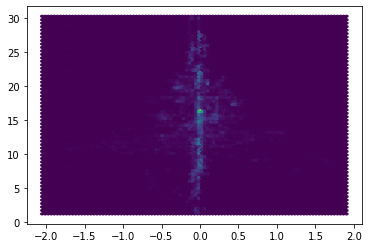

In [32]:
plt.hexbin(df['angle'].values,df['speed'].values)
plt.show()

In [33]:
max_vals = len(df[(np.abs(df.angle) >= 0.4)])
mid_vals = len(df[(np.abs(df.angle) >= 0.1) & (np.abs(df.angle) < 0.4)])
min_vals = len(df[(np.abs(df.angle) < 0.1)])
print(len(df), max_vals, mid_vals, min_vals)

101396 10664 29267 61465


In [34]:
def display_k(images, results):
    assert(len(images) == len(results))
    f, axes = plt.subplots(int(len(images)), 1, figsize=(5, 15))
    f.tight_layout()
    axes = np.reshape(axes, -1)
  
    for i in range(len(axes)):
        r = results[i]
        title_unformatted = "Speed: {0:.4f}" \
        "\nAngle: {1:.2f}"
        title = title_unformatted.format(r[1], r[0])

        axes[i].imshow(images[i])
        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')
    plt.subplots_adjust(top=0.85)
    plt.show()

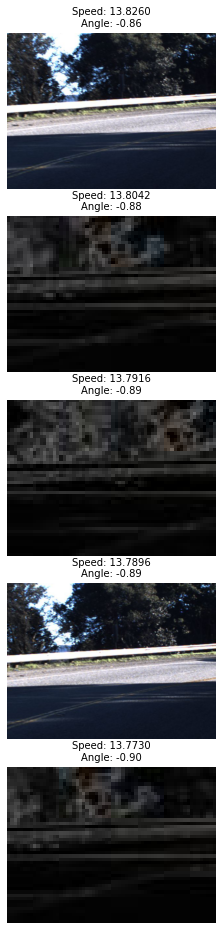

In [35]:
last_idx = df[df.angle < -0.9].index[0]
frames = df.iloc[last_idx-4:last_idx+1]

features = frames.filter(items = ['angle','speed']).values
image_files = [imageio.imread(f) for f in frames['filename'].values]

display_k(image_files, features)

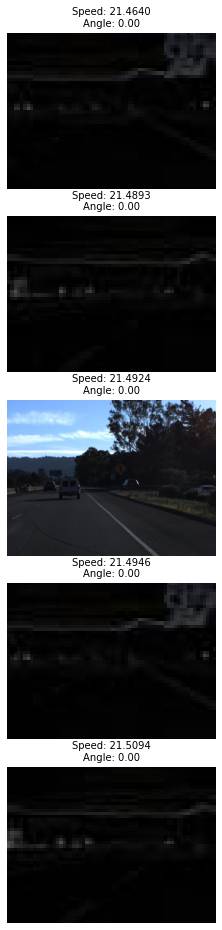

In [36]:
last_idx = df[df.angle == 0.].index[10]
frames = df.iloc[last_idx-4:last_idx+1]
features = frames.filter(items = ['angle','speed']).values
image_files = [imageio.imread(f) for f in frames['filename'].values]

display_k(image_files, features)

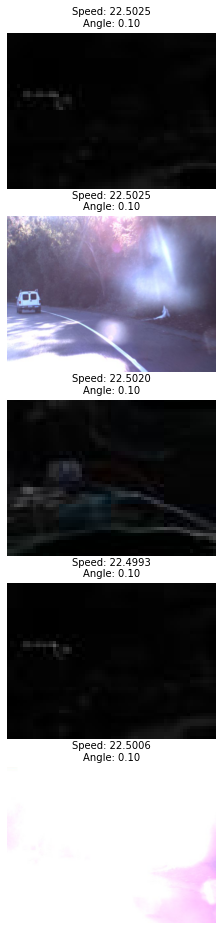

In [37]:
last_idx = df[(df.angle < 0.13) & (df.angle > 0.1)].index[10]
frames = df.iloc[last_idx-4:last_idx+1]
features = frames.filter(items = ['angle','speed']).values
image_files = [imageio.imread(f) for f in frames['filename'].values]

display_k(image_files, features)

In [38]:
import cv2
import numpy as np
import glob
 
img_array = []
for filename in glob.glob('right_sobel/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [39]:
import numpy as np
import cv2
from keras.models import load_model

model = load_model('model_final_exam.h5')

def keras_predict(model, image):
    processed = keras_process_image(image)
    steering_angle = float(model.predict(processed, batch_size=1))
    steering_angle = steering_angle
    return steering_angle


def keras_process_image(img):
    image_x = 48
    image_y = 64
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (-1, image_x, image_y, 3))
    return img


steer = cv2.imread('right_sobel/1479424221628199722.jpg', 0)
rows, cols = steer.shape
smoothed_angle = 0

cap = cv2.VideoCapture('project.avi')
while (cap.isOpened()):
    ret, frame = cap.read()
    steering_angle = keras_predict(model, frame)
    print(f'Predicted Steering Angle:',steering_angle)
    cv2.imshow('frame', cv2.resize(frame, (48, 64), interpolation=cv2.INTER_AREA))
    smoothed_angle += 0.2 * pow(abs((steering_angle - smoothed_angle)), 2.0 / 3.0) * (
        steering_angle - smoothed_angle) * abs(
        steering_angle - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), -smoothed_angle, 1)
    dst = cv2.warpAffine(steer, M, (cols, rows))
    cv2.imshow("steering wheel", dst)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

0.026024162769317627
0.005132199730724096
-1.141579270362854
-1.2357944250106812
-0.03735833242535591
-0.3524017632007599
0.14728279411792755
-0.24677680432796478
-0.030671490356326103
-0.5410624146461487
-0.7284705638885498
0.04477427527308464
0.45276907086372375
0.052315838634967804
0.22280991077423096
0.12512154877185822
0.005132199730724096
0.005132199730724096
-0.20318689942359924
0.10233361274003983
0.06703626364469528
0.005132199730724096
-0.8265643119812012
0.005132199730724096
0.005132199730724096
0.1210838258266449
-0.2540530860424042
-0.05543655529618263
0.005132199730724096
0.005132199730724096
-0.534744143486023
0.005132199730724096
0.019245948642492294
0.2949129045009613
-0.018474457785487175
0.7260838747024536
0.011455709114670753
0.005132199730724096
-0.594274640083313
-0.3114578127861023
0.005132199730724096
-0.23779885470867157
0.220988467335701
0.0027191140688955784
0.005132199730724096
-0.09808605164289474
-1.5140661001205444
-0.07618390768766403
-0.5600088238716125

0.005132199730724096
-0.04472755640745163
0.005132199730724096
0.005132199730724096
-0.18994326889514923
0.005132199730724096
0.005132199730724096
-0.037386100739240646
-0.426777720451355
0.056099701672792435
-0.13945330679416656
-0.33097684383392334
0.013236874714493752
0.2614198327064514
0.05157540366053581
-1.5599004030227661
0.005132199730724096
0.29034802317619324
-2.0572140216827393
0.03398395702242851
0.014740556478500366
-0.0174087043851614
0.005132199730724096
0.005132199730724096
-0.6365340352058411
-0.23978351056575775
0.005132199730724096
0.005132199730724096
0.13170883059501648
-0.5438579320907593
0.005132199730724096
0.12477017194032669
0.005132199730724096
0.1569332480430603
0.005132199730724096
-0.15741761028766632
-2.440927505493164
-0.7005872130393982
-0.7336205840110779
0.019797509536147118
-1.0185834169387817
0.005132199730724096
-0.02361384592950344
0.005132199730724096
0.20510615408420563
0.005132199730724096
0.005132199730724096
-0.007402782794088125
-0.194581314

0.002731690648943186
-0.12521307170391083
0.005132199730724096
0.0038130762986838818
-0.02389775775372982
0.302425742149353
-0.046652499586343765
0.02752744033932686
-1.8315290212631226
-2.5873889923095703
-0.07063207030296326
-0.0007333732210099697
0.029262017458677292
-0.13737253844738007
-0.8675376176834106
0.005132199730724096
-0.09799318760633469
0.36338284611701965
-0.19408321380615234
-1.6261012554168701
0.005132199730724096
0.02147151157259941
-0.05459602549672127
-0.2715674042701721
0.005132199730724096
0.01382080465555191
-0.2741132378578186
0.005132199730724096
0.08569545298814774
0.016770880669355392
0.09552723914384842
-0.016116579994559288
0.2551465630531311
0.39257189631462097
-2.2900640964508057
-0.0313260443508625
-0.6632686853408813
-0.5436447262763977
-0.22784902155399323
0.005132199730724096
0.005132199730724096
-0.3277919292449951
0.005132199730724096
-0.5418292284011841
0.0228255745023489
-0.25126326084136963
0.3296022415161133
0.005132199730724096
0.0451076515018

-1.443248987197876
0.02318032830953598
0.005132199730724096
0.005132199730724096
0.033800020813941956
0.005132199730724096
0.02950575016438961
0.06446351855993271
-0.5266431570053101
0.005132199730724096
-0.9858053922653198
0.7645184397697449
-0.21018372476100922
0.005132199730724096
0.005132199730724096
-0.4817967116832733
0.005132199730724096
-0.16141162812709808
-0.1152428686618805
-0.8632405400276184
-0.1617104560136795
-0.19567729532718658
0.41463303565979004
0.16548480093479156
-1.080255389213562
0.0032409564591944218
0.005132199730724096
2.1910500526428223
0.005132199730724096
0.005132199730724096
0.019379714503884315
-0.1191403791308403
-1.066458821296692
-2.41546630859375
-2.584317684173584
0.14207203686237335
0.022947974503040314
0.02964724786579609
0.004059384111315012
0.031495049595832825
0.21375377476215363
-1.4308773279190063
-0.0622587688267231
0.09038470685482025
-0.004011732060462236
0.18546277284622192
0.0217079296708107
-0.06873225420713425
0.005132199730724096
0.005

0.06660154461860657
0.005132199730724096
0.005132199730724096
-1.0245405435562134
0.005132199730724096
-1.2624026536941528
-1.6663650274276733
0.005132199730724096
0.26095253229141235
-1.3185757398605347
-0.2782537341117859
0.005132199730724096
0.005132199730724096
-0.728979229927063
0.2865820527076721
0.32689180970191956
0.053988467901945114
-0.7619683742523193
0.005132199730724096
-0.5945596694946289
0.005132199730724096
0.005132199730724096
-0.034795138984918594
0.03982437402009964
-2.074073314666748
0.017740372568368912
0.005132199730724096
0.005132199730724096
0.010801577940583229
0.48282578587532043
-0.1973273605108261
-3.1840734481811523
-0.14137186110019684
0.005132199730724096
-0.15557946264743805
0.02829672582447529
0.005132199730724096
0.1253984123468399
-1.1951589584350586
-0.21522794663906097
0.005132199730724096
-0.030179547145962715
0.005132199730724096
0.004122318234294653
-0.040656816214323044
-0.17576932907104492
-0.07437294721603394
0.11814219504594803
0.005132199730

0.005132199730724096
0.005132199730724096
-0.6744966506958008
-0.11252187937498093
0.5337480306625366
-0.40995365381240845
0.005132199730724096
-1.4203859567642212
0.011512527242302895
0.04162679240107536
-0.4850972592830658
0.009507638402283192
-1.2243813276290894
0.2995591163635254
0.20842494070529938
-0.2866142988204956
0.8388758897781372
-0.01873106323182583
0.03798902407288551
0.005132199730724096
0.005132199730724096
0.9443621635437012
0.005132199730724096
-3.2551050186157227
1.4569287300109863
-0.017963401973247528
0.17018167674541473
0.005132199730724096
0.07431361824274063
0.7135396599769592
0.00903652049601078
0.015375865623354912
-0.34344756603240967
0.01125338114798069
0.014927290380001068
0.17753827571868896
0.005132199730724096
-0.9705349206924438
-0.7368149757385254
-0.006399932783097029
0.005132199730724096
0.005132199730724096
0.17694737017154694
0.005132199730724096
-0.2334052175283432
0.005132199730724096
0.005132199730724096
0.5726670026779175
-0.3186494708061218
0.

-0.2808346748352051
-0.6400934457778931
0.005132199730724096
0.0329023115336895
-2.358708381652832
0.0748969092965126
0.005132199730724096
-0.6512691974639893
-0.45373809337615967
-0.09110613912343979
-0.5382607579231262
0.22151662409305573
0.11673679202795029
-2.5027780532836914
-0.45218390226364136
-0.9383317232131958
-0.33061036467552185
0.08132798224687576
0.1354777067899704
0.09495758265256882
0.4357232451438904
0.0567692369222641
0.046628113836050034
-2.099442720413208
1.2877572774887085
0.005132199730724096
0.04893368482589722
0.019995160400867462
-0.4182489812374115
-0.29853713512420654
0.3926454186439514
0.005132199730724096
-0.11584534496068954
0.03279300034046173
-0.012521250173449516
1.0337762832641602
-0.09895789623260498
0.04194866493344307
-0.33484435081481934
-1.9666002988815308
-0.33687824010849
0.07663307338953018
-0.9336308240890503
0.005132199730724096
0.8587436079978943
0.6167037487030029
0.04760349914431572
0.005132199730724096
-0.8396551012992859
-0.0710120722651

radius = 20

cap = cv2.VideoCapture('project.avi')

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
steering_video = cv2.VideoWriter('steering_video.avi',fourcc,15,(48,60),1)
while (cap.isOpened()):
    ret, frame = cap.read()
    predicted_angle = keras_predict(model, frame) # radians
    true_angle = y_test[50]
    print(f'Predicted Angle: ',predicted_angle)
    print(f'True Angle: ', true_angle)
    cv2.circle(frame,(30,48), radius, (255,0,255),thickness =1)
    
    x = int(radius * np.cos(np.pi/2 + true_angle))
    y = int(radius * np.sin(np.pi/2 + true_angle))
    cv2.circle(frame,(30+ int(x), 48-int(y)),1,(255,0,0), thickness =1)
    cv2.line(frame, (30+ int(x), 48-int(y)), (30,48),(255,180,120), thickness =1, lineType = 8)
    
    x = radius * np.cos(np.pi/2 + predicted_angle)
    y = radius * np.sin(np.pi/2 + predicted_angle)
    cv2.circle(frame,(30+ int(x), 48-int(y)),1,(0,255,255), thickness =1)
    cv2.line(frame,(30+ int(x), 48-int(y)),(30,48),(0,0,255), thickness =1, lineType = 8)
    
    steering_video.write(frame)
    plt.imshow(frame)
    plt.show()

steering_video.release()
cv2.destroyAllWindows()